In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_roc_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt

In [12]:
complete_ds = pd.read_csv("avail_complete.csv").sample(frac=0.35)

In [13]:
len(complete_ds)

3255383

In [14]:
complete_ds.head()

,Unnamed: 0.1,Unnamed: 0,station_id,hour,dow,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,status,minutes_bt_check,remaining_bikes_available
5578071,133416,153178,348,16,5,8,0,4,0,IN_SERVICE,2.0,9.0
2539173,2539173,1521620,82,20,4,2,1,17,0,IN_SERVICE,16.0,1.0
7946953,1213946,1025768,423,11,0,3,2,7,0,IN_SERVICE,14.0,3.0
4965541,2284879,1128137,200,21,2,6,0,10,0,IN_SERVICE,13.0,6.0
91266,91266,1112735,6,1,6,18,2,0,0,IN_SERVICE,1.0,18.0


In [15]:
complete_ds["remaining_bikes"] = (complete_ds["remaining_bikes_available"]>0).astype(int)

## Stations as models

In [16]:
FEATURES_ORDER = ["hour", "dow", "num_bikes_available", "num_bikes_disabled", "num_docks_available", "num_docks_disabled", "minutes_bt_check"]
TARGET = "remaining_bikes"
CLASS_WEIGHT = {0: 100, 1: 1}
OHE_SLICE = [0, 1]
SS_SLICE = slice(2,7)
TEST_SIZE = 0.2

In [17]:
station_ids = complete_ds["station_id"].unique()

lgb_metrics = dict(tn=0, fp=0, fn=0, tp=0)
for station_id in station_ids:
    station_ds = complete_ds[complete_ds["station_id"] == station_id]
    X_train, X_test, y_train, y_test = train_test_split(station_ds[FEATURES_ORDER].values, station_ds[TARGET].values, test_size=TEST_SIZE, shuffle=True)
    if len(station_ds[TARGET].unique()) == 1:
        y_train[0] = 0
        y_test[0] = 0
    lgb_pipeline = make_pipeline(
        ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), OHE_SLICE), ("ss",  StandardScaler(), SS_SLICE)]),
        LGBMClassifier(class_weight=CLASS_WEIGHT, n_estimators=10, max_depth=10))
    lgb_pipeline.fit(X_train, y_train)        
    tn, fp, fn, tp = confusion_matrix(y_test, lgb_pipeline.predict(X_test)).ravel()
    lgb_metrics["tn"] += tn
    lgb_metrics["fp"] += fp
    lgb_metrics["fn"] += fn
    lgb_metrics["tp"] += tp

In [18]:
lgb_metrics

{'tn': 35955, 'fp': 631, 'fn': 108566, 'tp': 506051}

In [19]:
tn_p = lgb_metrics["tn"] / (lgb_metrics["tn"]+lgb_metrics["fp"])
fp_p = lgb_metrics["fp"] / (lgb_metrics["tn"]+lgb_metrics["fp"])
fn_p = lgb_metrics["fn"] / (lgb_metrics["fn"]+lgb_metrics["tp"])
tp_p = lgb_metrics["tp"] / (lgb_metrics["fn"]+lgb_metrics["tp"])
print(f"tn: {tn_p}, fp: {fp_p}, fn: {fn_p}, tp: {tp_p}")

tn: 0.9827529656152627, fp: 0.01724703438473733, fn: 0.17664008642780787, tp: 0.8233599135721921


## Stations as features

In [7]:
FEATURES_ORDER_F = ["station_id", "hour", "dow", "num_bikes_available", "num_bikes_disabled", "num_docks_available", "num_docks_disabled", "minutes_bt_check"]
OHE_SLICE_F = [0, 1, 2]
SS_SLICE_F = slice(3,8)

In [8]:
station_ids = complete_ds["station_id"].unique()

X_train, X_test, y_train, y_test = train_test_split(complete_ds[FEATURES_ORDER_F].values, complete_ds[TARGET].values, test_size=TEST_SIZE, shuffle=True)
del complete_ds
lgb_pipeline = make_pipeline(
    ColumnTransformer([("ohe",  OneHotEncoder(sparse=False), OHE_SLICE_F), ("ss",  StandardScaler(), SS_SLICE_F)]),
    LGBMClassifier(class_weight=CLASS_WEIGHT, n_estimators=10, max_depth=10))
lgb_pipeline.fit(X_train, y_train)
tn_f, fp_f, fn_f, tp_f = confusion_matrix(y_test, lgb_pipeline.predict(X_test)).ravel()

In [9]:
print(f"tn: {tn_f}, fp: {fp_f}, fn: {fn_f}, tp: {tp_f}")

tn: 36579, fp: 160, fn: 184778, tp: 429560


In [21]:
tn_f_p = tn_f / (tn_f+fp_f)
fp_f_p = fp_f / (tn_f+fp_f)
fn_f_p = fn_f / (fn_f+tp_f)
tp_f_p = tp_f / (fn_f+tp_f)
print(f"tn: {tn_f_p}, fp: {fp_f_p}, fn: {fn_f_p}, tp: {tp_f_p}")

tn: 0.9956449549525028, fp: 0.00435504504749721, fn: 0.3007757944323809, tp: 0.6992242055676191


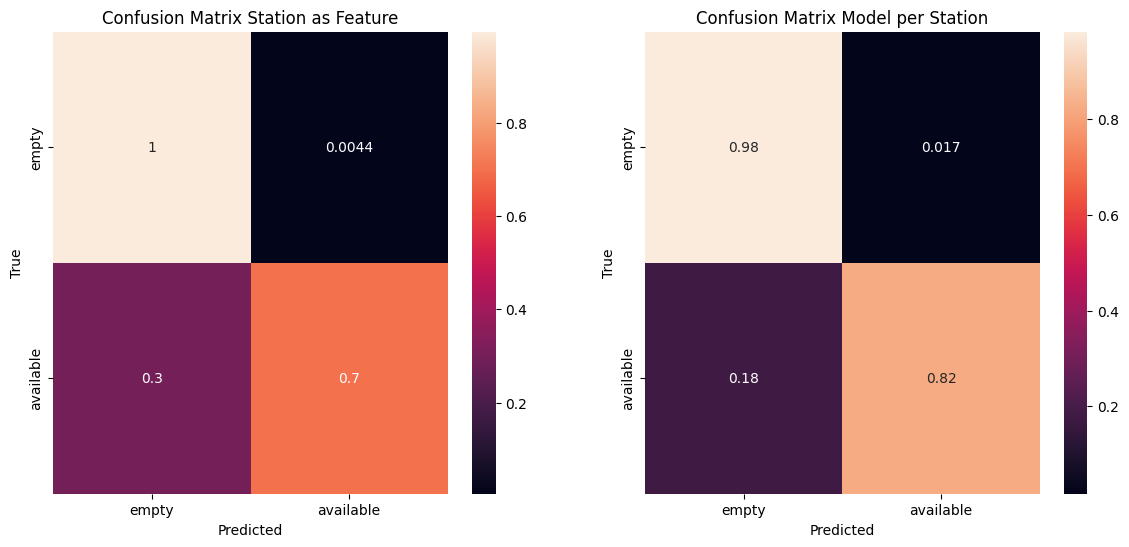

In [22]:
f, axs = plt.subplots(1,2, figsize=(14, 6))
df_cm = pd.DataFrame([[tn_f_p, fp_f_p], [fn_f_p, tp_f_p]], index = ["empty", "available"], columns = ["empty", "available"])
g = sns.heatmap(df_cm, annot=True, ax=axs[0])

g.set_xlabel('Predicted')
g.set_ylabel('True')
g.set_title('Confusion Matrix Station as Feature'); 

df_cm = pd.DataFrame([[tn_p, fp_p], [fn_p, tp_p]], index = ["empty", "available"], columns = ["empty", "available"])
g = sns.heatmap(df_cm, annot=True, ax=axs[1])

g.set_xlabel('Predicted')
g.set_ylabel('True')
g.set_title('Confusion Matrix Model per Station'); 

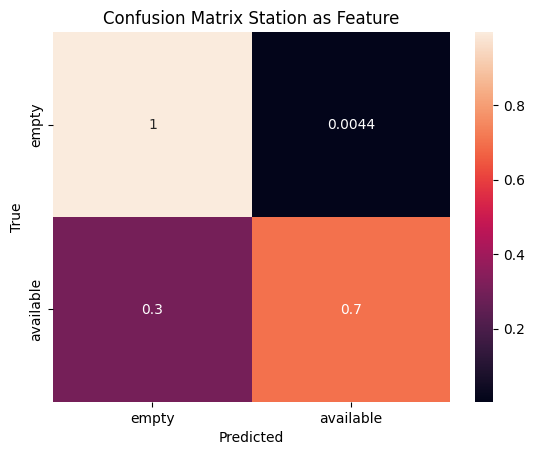

In [24]:
df_cm = pd.DataFrame([[tn_f_p, fp_f_p], [fn_f_p, tp_f_p]], index = ["empty", "available"], columns = ["empty", "available"])
g = sns.heatmap(df_cm, annot=True)

g.set_xlabel('Predicted')
g.set_ylabel('True')
g.set_title('Confusion Matrix Station as Feature'); 